In [1]:
from __future__ import division
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import sys
import scipy
import cv2
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
from glob import glob
import math
import tifffile as tiff
import PIL
from sklearn.cross_validation import train_test_split
from IPython.display import display, Image
from scipy.ndimage import filters
from scipy.spatial.distance import cdist,pdist,squareform
import scipy.spatial.distance as dist

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

C:\Users\alvaro.joao.silvino\AppData\Local\Continuum\Anaconda2\lib\site-packages\tifffile.py:276: UserWarning: ImportError: No module named '_tifffile'. Loading of some compressed images will be very slow. Tifffile.c can be obtained at http://www.lfd.uci.edu/~gohlke/
  "ImportError: No module named '_tifffile'. "


In [2]:
datasets = [ f for f in glob('datasets/*')  ]
datasets


['datasets\\blur_data-2',
 'datasets\\fluorescent_8_bit-9',
 'datasets\\metallic_16_bit-11',
 'datasets\\mondrian_16_bit-11',
 'datasets\\objects_16_bit-11',
 'datasets\\specular_16_bit-11',
 'datasets\\znovabase']

In [3]:
def img2array(im):
    if im.mode != 'RGB':
        im = im.convert(mode='RGB')
    return np.fromstring(im.tobytes(), dtype='uint8').reshape((im.size[1], im.size[0], 3))

def getBaseAndTarget(dataset,isTif18=True):
    data = []
    target = []
    for i,classe in enumerate(glob('%s/*'%dataset)):
        for f in glob('%s/*'%classe):
            if isTif18:
                data.append(tiff.imread(f))
            else:
                data.append(img2array(PIL.Image.open(f)))

            target.append(i)
    return data,target

def normalize(arr):
    ''' Function to normalize an input array to 0-1 '''
    arr_min = arr.min()
    arr_max = arr.max()
    return (arr - arr_min) / (arr_max - arr_min)
def normalize1(arr):
    """
    Linear normalization
    http://en.wikipedia.org/wiki/Normalization_%28image_processing%29
    """
    print("here")
    arr = arr.astype('float')
    # Do not touch the alpha channel
    for i in range(3):
        minval = arr[...,i].min()
        maxval = arr[...,i].max()
        if minval != maxval:
            arr[...,i] -= minval
            arr[...,i] *= (65535.0/(maxval-minval))
    return arr

In [4]:
def getHistogramP(image,logMethod=math.log,derivateMethod=filters.gaussian_laplace,sigma=2):
    
    image_R = image[:,:,0]
    image_G = image[:,:,1]
    image_B = image[:,:,2]
    ln_image_R = map(logMethod,image_R.ravel()+0.001)
    gaussina_laplace_ln_image_R =  derivateMethod(ln_image_R,sigma)

    ln_image_G = map(logMethod,image_G.ravel()+0.001)
    gaussina_laplace_ln_image_G =  derivateMethod(ln_image_G,sigma)

    ln_image_B = map(logMethod,image_B.ravel()+0.001)
    gaussina_laplace_ln_image_B =  derivateMethod(ln_image_B,sigma)
    
    data2 = np.vstack((gaussina_laplace_ln_image_R.flat, gaussina_laplace_ln_image_G.flat,
                       gaussina_laplace_ln_image_B.flat)).astype(np.float).T
    H, edges = np.histogramdd(data2, bins = (16, 16, 16),normed=False)

    return np.float32(cv2.normalize(H).flatten())

    
def getHistogramM(image,logMethod=math.log,derivateMethod=filters.gaussian_laplace,sigma=2):
    
    image_R = image[:,:,0]
    image_G = image[:,:,1]
    image_B = image[:,:,2]
    
    R = np.array(image_R.ravel()+0.0001,dtype=float)
    G = np.array(image_G.ravel()+0.0001,dtype=float)
    B = np.array(image_B.ravel()+0.0001,dtype=float)
    
    ln_image_R_divideG = map(logMethod,np.divide(R,G))
    gaussina_laplace_ln_image_R_divideG =  derivateMethod(ln_image_R_divideG,sigma)

    ln_image_B_divideG = map(logMethod,np.divide(B,G))
    gaussina_laplace_ln_image_B_divideG =  derivateMethod(ln_image_B_divideG,sigma)
    
    data2 = np.vstack((gaussina_laplace_ln_image_R_divideG.flat, gaussina_laplace_ln_image_B_divideG.flat)).astype(np.float).T
    H, edges = np.histogramdd(data2, bins = (16, 16),normed=False)
    return np.float32(cv2.normalize(H).flatten())

    
def getHistogramThip(image,logMethod=math.log,derivateMethod=filters.gaussian_laplace,sigma=2):
    
    image_R = image[:,:,0]
    image_G = image[:,:,1]
    image_B = image[:,:,2]
    
    
    R = np.array(image_R.ravel()+0.0001,dtype=float)
    G = np.array(image_G.ravel()+0.0001,dtype=float)
    B = np.array(image_B.ravel()+0.0001,dtype=float)
    
    ln_image_R = map(logMethod,R)
    gaussina_laplace_ln_image_R =  derivateMethod(ln_image_R,sigma)

    ln_image_G = map(logMethod,G)
    gaussina_laplace_ln_image_G =  derivateMethod(ln_image_G,sigma)

    ln_image_B = map(logMethod,B)
    gaussina_laplace_ln_image_B =  derivateMethod(ln_image_B,sigma)
    
    thip1 = np.array(map(lambda (x,y):math.atan2(x,y),zip(gaussina_laplace_ln_image_R,gaussina_laplace_ln_image_G)))
    thip2 = np.array(map(lambda (x,y):math.atan2(x,y),zip(gaussina_laplace_ln_image_G,gaussina_laplace_ln_image_B)))
    data2 = np.vstack((thip1.flat, thip2.flat)).astype(np.float).T
    H, edges = np.histogramdd(data2, bins = (16, 16),normed=False)
    return np.float32(cv2.normalize(H).flatten())
      
def getHistogramThipM(image,logMethod=math.log,derivateMethod=filters.gaussian_laplace,sigma=2):
    
    
    image_R = image[:,:,0]
    image_G = image[:,:,1]
    image_B = image[:,:,2]
    
    
    R = np.array(image_R.ravel()+0.0001,dtype=float)
    G = np.array(image_G.ravel()+0.0001,dtype=float)
    B = np.array(image_B.ravel()+0.0001,dtype=float)
    
    ln_image_R_divideG = map(logMethod,np.divide(R,G))
    gaussina_laplace_ln_image_R_divideG =  derivateMethod(ln_image_R_divideG,sigma)

    ln_image_B_divideG = map(logMethod,np.divide(G,B))
    gaussina_laplace_ln_image_B_divideG =  derivateMethod(ln_image_B_divideG,sigma)

    
    thipm = np.array(map(lambda (x,y):math.atan2(x,y),zip(gaussina_laplace_ln_image_R_divideG,gaussina_laplace_ln_image_B_divideG)))
    data2 = thipm.flat
    H, edges = np.histogramdd(data2, bins = (16),normed=False)
    return np.float32(cv2.normalize(H).flatten())

def getHistogramThipMWithDerivateAndSquare(image,logMethod=math.log,derivateMethod=filters.gaussian_laplace,sigma=2):
    
    image_R = image[:,:,0]
    image_G = image[:,:,1]
    image_B = image[:,:,2]
    
    R = np.array(image_R.ravel()+0.0001,dtype=float)
    G = np.array(image_G.ravel()+0.0001,dtype=float)
    B = np.array(image_B.ravel()+0.0001,dtype=float)
    
    
    ln_image_R_divideG = map(logMethod,np.divide(R,G))
    gaussina_laplace_ln_image_R_divideG =  derivateMethod(ln_image_R_divideG,sigma)
    ln_image_B_divideG = map(logMethod,np.divide(G,B))
    gaussina_laplace_ln_image_B_divideG =  derivateMethod(ln_image_B_divideG,sigma)
    
    thipm = np.array(map(lambda (x,y):math.atan2(x,y),zip(gaussina_laplace_ln_image_R_divideG,gaussina_laplace_ln_image_B_divideG)))
    
    gaussina_laplace_thipm =  derivateMethod(thipm,sigma)
    
#     upPart = map(lambda x:math.pow(x,2),derivateMethod(gaussina_laplace_ln_image_R_divideG,sigma))
#     bottonPart = map(lambda (x,y):math.sqrt(math.pow(x,2)+math.pow(y,2)),
#                      zip(gaussina_laplace_ln_image_R_divideG,gaussina_laplace_ln_image_B_divideG))

#     finalPart = np.array(map(lambda (x,y):x/(y+0000.1),zip(upPart,bottonPart)))
    finalPart = np.array(map(lambda x:math.pow(x,2),gaussina_laplace_thipm))

    data2 = finalPart.flat

    H, edges = np.histogramdd(data2, bins = (16),normed=False)
    return np.float32(cv2.normalize(H).flatten())
    

In [5]:
#Computing histogram
def computeHistogram(train,test,method,*args):
    train_histo = {}
    test_histo = {}

    for i,imageTrain in enumerate(train):
        train_histo[i]= method(imageTrain,*args)
    for i,imageTest in enumerate(test):
        test_histo[i]= method(imageTest,*args)
    
    return train_histo,test_histo

def calcRanks(train_histogram_dict,train_target,test_histogram_dict,test_target,nr=1):
    allTestRanked = []
    for test_id in test_histogram_dict:
        allDistances=[]
        for train_id in train_histogram_dict:
            d = dist.euclidean(train_histogram_dict[train_id], test_histogram_dict[test_id])
            allDistances.append((train_id,d,train_target[train_id]))
        allDistances = sorted(allDistances,key=lambda x:x[1],reverse=False)
        allTestRanked.append((test_id,[ i+1 for i,(x,d,target) in enumerate(allDistances) if  target == test_target[test_id]][:]))
    return allTestRanked



In [6]:
import scipy
def nar(ranks,n):
    result = 0
    nr = len(ranks)
    for (ri) in ranks:
        result += ri-((nr*(nr+1))/2)
    result*=(1/(n*nr))
    
    return result
def anar(allRanks):
    n = len(allRanks)*len(allRanks[0][1])
    return scipy.mean(map(lambda (x,y):nar(y,n),allRanks))



In [7]:
def calcKnn(allRanks,k=1):
    hits = 0
    for (i,rankedImage) in allRanks:
        votes = 0
        for rank in rankedImage[:k]:
            if rank in range(1,k+1):
                votes+=1
        if votes>k/2:
            hits+=1
    return hits/len(allRanks)

In [8]:
def plot_gallery(title, images, n_col, n_row,image_shape = (28, 28)):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(normalize(comp.reshape(image_shape)), cmap=plt.cm.gray,            
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)
    plt.show()   

In [85]:
ranked = [(0, [1, 17, 19, 20, 21, 22, 23, 24]), (1, [1, 2, 3, 4, 6, 7, 13, 24]), (2, [1, 2, 34, 36, 44, 45, 46, 48]), (3, [1, 2, 3, 4, 5, 6, 7, 16]), (4, [1, 2, 3, 4, 5, 6, 7, 21]), (5, [2, 6, 9, 10, 12, 14, 16, 19])]
rr=[(0, [23, 39, 46, 60, 64, 71, 105, 108, 144, 196]), (1, [2, 5, 8, 32, 33, 48, 73, 188, 198, 199]), (2, [2, 3, 11, 64, 79, 95, 107, 125, 148, 160]), (3, [7, 12, 21, 54, 58, 87, 138, 168, 170, 173]), (4, [8, 50, 73, 75, 81, 82, 131, 133, 134, 157]), (5, [16, 23, 33, 64, 66, 71, 77, 78, 81, 108]), (6, [3, 7, 21, 33, 41, 77, 89, 95, 132, 164]), (7, [18, 21, 34, 40, 56, 99, 135, 144, 145, 169]), (8, [1, 3, 4, 59, 61, 68, 69, 70, 78, 113]), (9, [1, 2, 15, 17, 19, 20, 24, 30, 45, 53]), (10, [1, 29, 40, 42, 54, 82, 102, 149, 151, 172]), (11, [5, 11, 17, 22, 25, 32, 34, 38, 48, 92]), (12, [4, 5, 80, 87, 128, 151, 159, 170, 171, 174]), (13, [1, 12, 17, 23, 32, 44, 48, 50, 106, 122]), (14, [97, 109, 118, 120, 133, 145, 155, 168, 180, 186]), (15, [45, 53, 66, 79, 80, 82, 94, 107, 123, 148]), (16, [16, 17, 21, 57, 61, 65, 68, 144, 153, 166]), (17, [5, 15, 37, 39, 93, 115, 134, 138, 151, 195]), (18, [25, 31, 38, 101, 110, 123, 159, 167, 180, 190]), (19, [1, 17, 20, 21, 26, 48, 51, 79, 83, 161])]
print(calcKnn(ranked))
print(anar(ranked))
print(anar(rr))



0.833333333333
-0.470486111111
0.111975


Tabela 1 Utilização de uma parte da base Saimon Fraser
-----
- 20 Objetos sem filtros 
-----
- 20 objetos com filtro gaussiano para embassar com desvio = 2
-----

In [75]:
print(datasets[4])
np_images,target = getBaseAndTarget(datasets[4],isTif18=True)

images_train, images_test, target_train, target_test = train_test_split(np_images, target, 
                                                                        test_size=len(set(target)), random_state=42,stratify=target)

images_train = map(lambda x:filters.gaussian_filter(x,(2,2,0), order=0),images_test)
target_train = target_test
print(len(images_train),len(images_test))
target_test


datasets\objects_16_bit-11
20 20


[2, 13, 1, 19, 8, 15, 3, 6, 18, 12, 7, 0, 4, 11, 10, 17, 14, 5, 9, 16]

In [76]:
train_histoP,test_histoP = computeHistogram(images_train,images_test,getHistogramP,math.log,filters.gaussian_laplace)
allTestRanked = calcRanks(train_histoP,target_train,test_histoP,target_test)
print(allTestRanked)
r = anar(allTestRanked)
print("knn para %.3f k=1"%calcKnn(allTestRanked,k=1))

print("P 3D gaussian_laplace %.3f"%r)

train_histoP,test_histoP = computeHistogram(images_train,images_test,getHistogramM,math.log,filters.gaussian_laplace)
allTestRanked = calcRanks(train_histoP,target_train,test_histoP,target_test)
print(allTestRanked)
r = anar(allTestRanked)
print("knn para %.3f k=1"%calcKnn(allTestRanked,k=1))

print("M 2D gaussian_laplace %.3f"%r)

train_histoP,test_histoP = computeHistogram(images_train,images_test,getHistogramThip,math.log,filters.gaussian_laplace)
allTestRanked = calcRanks(train_histoP,target_train,test_histoP,target_test)
print(allTestRanked)
r = anar(allTestRanked)
print("knn para %.3f k=1"%calcKnn(allTestRanked,k=1))

print("Thi P 2D gaussian_laplace %.3f"%r)

train_histoP,test_histoP = computeHistogram(images_train,images_test,getHistogramThipM,math.log,filters.gaussian_laplace)
allTestRanked = calcRanks(train_histoP,target_train,test_histoP,target_test)
print(allTestRanked)
r = anar(allTestRanked)
print("knn para %.3f k=1"%calcKnn(allTestRanked,k=1))

print("Thi M 1D gaussian_laplace %.3f"%r)





[(0, [13]), (1, [1]), (2, [10]), (3, [13]), (4, [7]), (5, [6]), (6, [6]), (7, [15]), (8, [1]), (9, [14]), (10, [7]), (11, [2]), (12, [8]), (13, [18]), (14, [1]), (15, [17]), (16, [16]), (17, [12]), (18, [20]), (19, [17])]
knn para 0.150 k=1
P 3D gaussian_laplace 0.460
[(0, [19]), (1, [1]), (2, [9]), (3, [15]), (4, [3]), (5, [12]), (6, [7]), (7, [19]), (8, [19]), (9, [14]), (10, [10]), (11, [2]), (12, [15]), (13, [10]), (14, [12]), (15, [9]), (16, [6]), (17, [9]), (18, [4]), (19, [18])]
knn para 0.050 k=1
M 2D gaussian_laplace 0.483
[(0, [2]), (1, [3]), (2, [1]), (3, [3]), (4, [2]), (5, [1]), (6, [2]), (7, [1]), (8, [1]), (9, [1]), (10, [1]), (11, [2]), (12, [2]), (13, [1]), (14, [1]), (15, [1]), (16, [4]), (17, [1]), (18, [1]), (19, [1])]
knn para 0.600 k=1
Thi P 2D gaussian_laplace 0.030
[(0, [2]), (1, [6]), (2, [2]), (3, [4]), (4, [1]), (5, [1]), (6, [4]), (7, [2]), (8, [3]), (9, [1]), (10, [2]), (11, [7]), (12, [4]), (13, [1]), (14, [1]), (15, [2]), (16, [1]), (17, [1]), (18, [4]), 

- Tabela 2
------
Base de dados fluorescent_8_bit 
------

In [86]:
print(datasets[1])
np_images,target = getBaseAndTarget(datasets[1],isTif18=False)
images_train, images_test, target_train, target_test = train_test_split(np_images, target, 
                                                                        test_size=len(set(target)), random_state=42,stratify=target)
print(len(images_train),len(images_test))
target_test

datasets\objects_16_bit-11
200 20


[2, 13, 1, 19, 8, 15, 3, 6, 18, 12, 7, 0, 4, 11, 10, 17, 14, 5, 9, 16]

In [74]:
train_histoP,test_histoP = computeHistogram(images_train,images_test,getHistogramP,math.log,filters.gaussian_laplace)
allTestRanked = calcRanks(train_histoP,target_train,test_histoP,target_test)
r = anar(allTestRanked)
print("P 3D gaussian_laplace knn para %.3f k=1"%calcKnn(allTestRanked,k=1))
print("P 3D gaussian_laplace knn para %.3f k=3"%calcKnn(allTestRanked,k=3))
print("P 3D gaussian_laplace knn para %.3f k=5"%calcKnn(allTestRanked,k=5))
print("P 3D gaussian_laplace %.3f"%r)
print(allTestRanked)

train_histoP,test_histoP = computeHistogram(images_train,images_test,getHistogramM,math.log,filters.gaussian_laplace)
allTestRanked = calcRanks(train_histoP,target_train,test_histoP,target_test)
r = anar(allTestRanked)
print("M 2D gaussian_laplace  knn para %.3f k=1"%calcKnn(allTestRanked,k=1))
print("M 2D gaussian_laplace  knn para %.3f k=3"%calcKnn(allTestRanked,k=3))
print("M 2D gaussian_laplace  knn para %.3f k=5"%calcKnn(allTestRanked,k=4))
print("M 2D gaussian_laplace %.3f"%r)
print(allTestRanked)

train_histoP,test_histoP = computeHistogram(images_train,images_test,getHistogramThip,math.log,filters.gaussian_laplace)
allTestRanked = calcRanks(train_histoP,target_train,test_histoP,target_test)
r = anar(allTestRanked)
print("Thi P 2D gaussian_laplace knn para %.3f k=1"%calcKnn(allTestRanked,k=1))
print("Thi P 2D gaussian_laplace knn para %.3f k=3"%calcKnn(allTestRanked,k=3))
print("Thi P 2D gaussian_laplace knn para %.3f k=5"%calcKnn(allTestRanked,k=5))
print("Thi P 2D gaussian_laplace %.3f"%r)
print(allTestRanked)

train_histoP,test_histoP = computeHistogram(images_train,images_test,getHistogramThipM,math.log,filters.gaussian_laplace)
allTestRanked = calcRanks(train_histoP,target_train,test_histoP,target_test)
r = anar(allTestRanked)
print("Thi M 1D gaussian_laplace knn para %.3f k=1"%calcKnn(allTestRanked,k=1))
print("Thi M 1D gaussian_laplace knn para %.3f k=3"%calcKnn(allTestRanked,k=3))
print("Thi M 1D gaussian_laplace knn para %.3f k=5"%calcKnn(allTestRanked,k=5))

print("Thi M 1D gaussian_laplace %.3f"%r)
print(allTestRanked)





P 3D gaussian_laplace knn para 0.833 k=1
P 3D gaussian_laplace knn para 0.667 k=3
P 3D gaussian_laplace knn para 0.500 k=5
P 3D gaussian_laplace -0.470
[(0, [1, 17, 19, 20, 21, 22, 23, 24]), (1, [1, 2, 3, 4, 6, 7, 13, 24]), (2, [1, 2, 34, 36, 44, 45, 46, 48]), (3, [1, 2, 3, 4, 5, 6, 7, 16]), (4, [1, 2, 3, 4, 5, 6, 7, 21]), (5, [2, 6, 9, 10, 12, 14, 16, 19])]
M 2D gaussian_laplace  knn para 0.667 k=1
M 2D gaussian_laplace  knn para 0.333 k=3
M 2D gaussian_laplace  knn para 0.000 k=5
M 2D gaussian_laplace -0.284
[(0, [1, 4, 13, 14, 18, 28, 37, 38]), (1, [3, 5, 8, 15, 29, 32, 34, 35]), (2, [1, 8, 11, 12, 13, 14, 32, 39]), (3, [1, 2, 42, 43, 45, 46, 47, 48]), (4, [2, 5, 17, 27, 33, 34, 38, 43]), (5, [1, 2, 7, 15, 23, 27, 39, 42])]
Thi P 2D gaussian_laplace knn para 1.000 k=1
Thi P 2D gaussian_laplace knn para 1.000 k=3
Thi P 2D gaussian_laplace knn para 1.000 k=5
Thi P 2D gaussian_laplace -0.645
[(0, [1, 2, 3, 4, 5, 6, 14, 22]), (1, [1, 2, 3, 4, 5, 6, 7, 8]), (2, [1, 2, 3, 4, 5, 6, 7, 8]),

Tabela 3 - Utilização de uma parte da base Saimon Fraser
-----
- 20 Objetos sem tranformação afim  
-----
- 20 Objetos com tranformação afim  
------

In [81]:
print(datasets[4])
np_images,target = getBaseAndTarget(datasets[4],isTif18=True)

images_train, images_test, target_train, target_test = train_test_split(np_images, target, 
                                                                        test_size=len(set(target)), random_state=42,stratify=target)

pts1 = np.float32([[50,50],[200,50],[50,200]])
pts2 = np.float32([[10,100],[200,50],[100,250]])
M = cv2.getAffineTransform(pts1,pts2)

images_train = map(lambda x:cv2.warpAffine(x,M,x.shape[:2]),images_test)
target_train = target_test
print(len(images_train),len(images_test))
target_test


datasets\objects_16_bit-11
20 20


[2, 13, 1, 19, 8, 15, 3, 6, 18, 12, 7, 0, 4, 11, 10, 17, 14, 5, 9, 16]

In [82]:
train_histoP,test_histoP = computeHistogram(images_train,images_test,getHistogramP,math.log,filters.gaussian_laplace)
allTestRanked = calcRanks(train_histoP,target_train,test_histoP,target_test)
print(allTestRanked)
r = anar(allTestRanked)
print("knn para %.3f k=1"%calcKnn(allTestRanked,k=1))
print("P 3D gaussian_laplace %.3f"%r)

train_histoP,test_histoP = computeHistogram(images_train,images_test,getHistogramM,math.log,filters.gaussian_laplace)
allTestRanked = calcRanks(train_histoP,target_train,test_histoP,target_test)
print(allTestRanked)
r = anar(allTestRanked)
print("knn para %.3f k=1"%calcKnn(allTestRanked,k=1))
print("M 2D gaussian_laplace %.3f"%r)

train_histoP,test_histoP = computeHistogram(images_train,images_test,getHistogramThip,math.log,filters.gaussian_laplace)
allTestRanked = calcRanks(train_histoP,target_train,test_histoP,target_test)
print(allTestRanked)
r = anar(allTestRanked)
print("knn para %.3f k=1"%calcKnn(allTestRanked,k=1))
print("Thi P 2D gaussian_laplace %.3f"%r)

train_histoP,test_histoP = computeHistogram(images_train,images_test,getHistogramThipM,math.log,filters.gaussian_laplace)
allTestRanked = calcRanks(train_histoP,target_train,test_histoP,target_test)
print(allTestRanked)
r = anar(allTestRanked)
print("knn para %.3f k=1"%calcKnn(allTestRanked,k=1))
print("Thi M 1D gaussian_laplace %.3f"%r)





[(0, [1]), (1, [4]), (2, [8]), (3, [1]), (4, [3]), (5, [18]), (6, [9]), (7, [1]), (8, [9]), (9, [18]), (10, [16]), (11, [14]), (12, [1]), (13, [20]), (14, [16]), (15, [5]), (16, [9]), (17, [7]), (18, [3]), (19, [18])]
knn para 0.200 k=1
P 3D gaussian_laplace 0.403
[(0, [4]), (1, [17]), (2, [9]), (3, [4]), (4, [3]), (5, [10]), (6, [7]), (7, [17]), (8, [18]), (9, [6]), (10, [10]), (11, [5]), (12, [15]), (13, [4]), (14, [6]), (15, [1]), (16, [10]), (17, [16]), (18, [4]), (19, [9])]
knn para 0.050 k=1
M 2D gaussian_laplace 0.388
[(0, [2]), (1, [3]), (2, [3]), (3, [5]), (4, [1]), (5, [2]), (6, [2]), (7, [3]), (8, [1]), (9, [1]), (10, [5]), (11, [1]), (12, [1]), (13, [1]), (14, [4]), (15, [5]), (16, [3]), (17, [8]), (18, [1]), (19, [1])]
knn para 0.400 k=1
Thi P 2D gaussian_laplace 0.083
[(0, [4]), (1, [1]), (2, [11]), (3, [7]), (4, [2]), (5, [4]), (6, [8]), (7, [4]), (8, [5]), (9, [1]), (10, [10]), (11, [3]), (12, [9]), (13, [1]), (14, [9]), (15, [12]), (16, [5]), (17, [15]), (18, [4]), (19

Tabela 4 - Utilização da base Real World Blurred Data 
-----
- 20 Objetos não embasados 
-----
- 20 Objetos embasados produzidos pela câmera
------

In [77]:
print(datasets[0])
np_images,target = getBaseAndTarget(datasets[0],False)
print(len(np_images))
images_train, images_test, target_train, target_test = train_test_split(np_images, target, 
                                                                        test_size=len(set(target)), random_state=42,stratify=target)
print(len(images_train),len(images_test))
target_test


datasets\blur_data-2
40
20 20


[19, 10, 7, 12, 9, 5, 17, 0, 3, 1, 13, 8, 15, 6, 16, 4, 2, 11, 18, 14]

In [78]:
train_histoP,test_histoP = computeHistogram(images_train,images_test,getHistogramP,math.log,filters.gaussian_laplace)
allTestRanked = calcRanks(train_histoP,target_train,test_histoP,target_test)
print(allTestRanked)
r = anar(allTestRanked)
print("knn para %.3f k=1"%calcKnn(allTestRanked,k=1))

print("P 3D gaussian_laplace %.3f"%r)

train_histoP,test_histoP = computeHistogram(images_train,images_test,getHistogramM,math.log,filters.gaussian_laplace)
allTestRanked = calcRanks(train_histoP,target_train,test_histoP,target_test)
print(allTestRanked)
r = anar(allTestRanked)
print("knn para %.3f k=1"%calcKnn(allTestRanked,k=1))
print("M 2D gaussian_laplace %.3f"%r)

train_histoP,test_histoP = computeHistogram(images_train,images_test,getHistogramThip,math.log,filters.gaussian_laplace)
allTestRanked = calcRanks(train_histoP,target_train,test_histoP,target_test)
print(allTestRanked)
r = anar(allTestRanked)
print("knn para %.3f k=1"%calcKnn(allTestRanked,k=1))
print("Thi P 2D gaussian_laplace %.3f"%r)

train_histoP,test_histoP = computeHistogram(images_train,images_test,getHistogramThipM,math.log,filters.gaussian_laplace)
allTestRanked = calcRanks(train_histoP,target_train,test_histoP,target_test)
print(allTestRanked)
r = anar(allTestRanked)
print("knn para %.3f k=1"%calcKnn(allTestRanked,k=1))
print("Thi M 1D gaussian_laplace %.3f"%r)





[(0, [13]), (1, [2]), (2, [6]), (3, [14]), (4, [1]), (5, [1]), (6, [14]), (7, [19]), (8, [3]), (9, [18]), (10, [13]), (11, [1]), (12, [7]), (13, [1]), (14, [20]), (15, [6]), (16, [10]), (17, [16]), (18, [2]), (19, [8])]
knn para 0.200 k=1
P 3D gaussian_laplace 0.388
[(0, [6]), (1, [2]), (2, [11]), (3, [7]), (4, [3]), (5, [20]), (6, [2]), (7, [18]), (8, [14]), (9, [4]), (10, [8]), (11, [7]), (12, [8]), (13, [4]), (14, [20]), (15, [2]), (16, [4]), (17, [15]), (18, [2]), (19, [4])]
knn para 0.000 k=1
M 2D gaussian_laplace 0.353
[(0, [1]), (1, [1]), (2, [1]), (3, [1]), (4, [1]), (5, [1]), (6, [1]), (7, [1]), (8, [2]), (9, [9]), (10, [2]), (11, [1]), (12, [1]), (13, [1]), (14, [1]), (15, [1]), (16, [1]), (17, [1]), (18, [1]), (19, [1])]
knn para 0.850 k=1
Thi P 2D gaussian_laplace 0.025
[(0, [2]), (1, [1]), (2, [2]), (3, [1]), (4, [1]), (5, [4]), (6, [1]), (7, [2]), (8, [3]), (9, [4]), (10, [2]), (11, [2]), (12, [1]), (13, [1]), (14, [1]), (15, [1]), (16, [2]), (17, [1]), (18, [1]), (19, [1

Tabela 5
------
Todos os objetos reunidos nas bases de imagens Saimon Fraser 56 objetos 616 imagens ao total
-----

In [9]:
print(datasets[-1])
np_images,target = getBaseAndTarget(datasets[-1],isTif18=True)

images_train, images_test, target_train, target_test = train_test_split(np_images, target, 
                                                                        test_size=len(set(target)), random_state=42,stratify=target)
print(len(images_train),len(images_test))
target_test

datasets\znovabase
560 56


[18,
 6,
 39,
 48,
 52,
 23,
 16,
 2,
 36,
 8,
 13,
 21,
 41,
 37,
 31,
 27,
 53,
 40,
 20,
 15,
 51,
 34,
 32,
 38,
 29,
 14,
 0,
 24,
 17,
 49,
 12,
 33,
 50,
 43,
 22,
 55,
 5,
 9,
 10,
 19,
 54,
 47,
 42,
 25,
 45,
 35,
 30,
 26,
 1,
 44,
 11,
 3,
 46,
 28,
 4,
 7]

In [10]:
train_histoP,test_histoP = computeHistogram(images_train,images_test,getHistogramP,math.log,filters.gaussian_laplace)
allTestRanked = calcRanks(train_histoP,target_train,test_histoP,target_test)
r = anar(allTestRanked)
print("P 3D gaussian_laplace knn para %.3f k=1"%calcKnn(allTestRanked,k=1))
print("P 3D gaussian_laplace knn para %.3f k=3"%calcKnn(allTestRanked,k=3))
print("P 3D gaussian_laplace knn para %.3f k=5"%calcKnn(allTestRanked,k=5))
print("P 3D gaussian_laplace %.3f"%r)
print(allTestRanked)

train_histoP,test_histoP = computeHistogram(images_train,images_test,getHistogramM,math.log,filters.gaussian_laplace)
allTestRanked = calcRanks(train_histoP,target_train,test_histoP,target_test)
r = anar(allTestRanked)
print("M 2D gaussian_laplace  knn para %.3f k=1"%calcKnn(allTestRanked,k=1))
print("M 2D gaussian_laplace  knn para %.3f k=3"%calcKnn(allTestRanked,k=3))
print("M 2D gaussian_laplace  knn para %.3f k=5"%calcKnn(allTestRanked,k=4))
print("M 2D gaussian_laplace %.3f"%r)
print(allTestRanked)

train_histoP,test_histoP = computeHistogram(images_train,images_test,getHistogramThip,math.log,filters.gaussian_laplace)
allTestRanked = calcRanks(train_histoP,target_train,test_histoP,target_test)
r = anar(allTestRanked)
print("Thi P 2D gaussian_laplace knn para %.3f k=1"%calcKnn(allTestRanked,k=1))
print("Thi P 2D gaussian_laplace knn para %.3f k=3"%calcKnn(allTestRanked,k=3))
print("Thi P 2D gaussian_laplace knn para %.3f k=5"%calcKnn(allTestRanked,k=5))
print("Thi P 2D gaussian_laplace %.3f"%r)
print(allTestRanked)

train_histoP,test_histoP = computeHistogram(images_train,images_test,getHistogramThipM,math.log,filters.gaussian_laplace)
allTestRanked = calcRanks(train_histoP,target_train,test_histoP,target_test)
r = anar(allTestRanked)
print("Thi M 1D blu knn para %.3f k=1"%calcKnn(allTestRanked,k=1))
print("Thi M 1D gaussian_laplace knn para %.3f k=3"%calcKnn(allTestRanked,k=3))
print("Thi M 1D gaussian_laplace knn para %.3f k=5"%calcKnn(allTestRanked,k=5))

print("Thi M 1D gaussian_laplace %.3f"%r)
print(allTestRanked)





P 3D gaussian_laplace knn para 0.393 k=1
P 3D gaussian_laplace knn para 0.125 k=3
P 3D gaussian_laplace knn para 0.054 k=5
P 3D gaussian_laplace 0.253
[(0, [37, 46, 87, 110, 121, 132, 149, 154, 175, 391]), (1, [18, 61, 76, 155, 156, 164, 199, 263, 316, 354]), (2, [1, 44, 79, 211, 314, 323, 329, 388, 444, 459]), (3, [1, 11, 27, 91, 114, 140, 155, 219, 243, 379]), (4, [40, 100, 103, 337, 461, 467, 506, 509, 531, 532]), (5, [7, 142, 151, 206, 245, 303, 329, 344, 366, 367]), (6, [1, 3, 22, 54, 66, 80, 81, 204, 318, 409]), (7, [5, 7, 32, 56, 80, 110, 206, 428, 498, 530]), (8, [1, 6, 7, 11, 22, 72, 151, 183, 439, 451]), (9, [15, 38, 66, 98, 99, 173, 192, 207, 287, 369]), (10, [1, 15, 136, 147, 154, 172, 173, 232, 255, 288]), (11, [1, 2, 3, 6, 10, 15, 59, 74, 236, 389]), (12, [219, 229, 350, 442, 456, 457, 461, 477, 478, 507]), (13, [1, 42, 46, 51, 57, 60, 193, 210, 258, 260]), (14, [2, 4, 6, 11, 12, 80, 155, 158, 189, 212]), (15, [9, 140, 177, 278, 279, 281, 292, 305, 471, 478]), (16, [7, 12

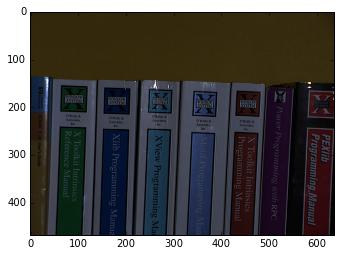

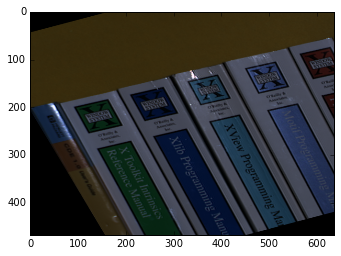

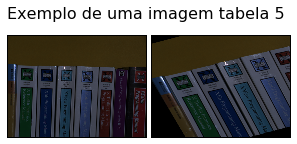

array([[[ 0.21322957,  0.1729305 ,  0.07612726],
        [ 0.1632105 ,  0.13142596,  0.0296025 ],
        [ 0.18999008,  0.15304799,  0.04678416],
        ..., 
        [ 0.14068818,  0.11194018,  0.04028382],
        [ 0.13879606,  0.11067369,  0.04139773],
        [ 0.1401236 ,  0.11165026,  0.04248112]],

       [[ 0.21574731,  0.16896315,  0.07388418],
        [ 0.16482795,  0.12950332,  0.02720684],
        [ 0.19293507,  0.15638972,  0.04885939],
        ..., 
        [ 0.14320592,  0.1142443 ,  0.04026856],
        [ 0.1404593 ,  0.11419852,  0.04234379],
        [ 0.14175631,  0.11572442,  0.04443427]],

       [[ 0.21930266,  0.17270161,  0.07663081],
        [ 0.1631342 ,  0.12832837,  0.02619974],
        [ 0.19053941,  0.15551995,  0.04818799],
        ..., 
        [ 0.14573892,  0.11480888,  0.04373236],
        [ 0.14509804,  0.11514458,  0.04530404],
        [ 0.14589151,  0.12019532,  0.04827955]],

       ..., 
       [[ 0.19645991,  0.16023499,  0.08773938],
        

In [27]:
img = images_test[0]#cv2.imread('drawing.png')
rows,cols,ch = img.shape

pts1 = np.float32([[50,50],[200,50],[50,200]])
pts2 = np.float32([[10,100],[200,50],[100,250]])

M = cv2.getAffineTransform(pts1,pts2)

dst = cv2.warpAffine(img,M,(cols,rows))

rows,cols = img.shape[:2]
rows,cols

plt.figure()
plt.imshow(normalize(img))
plt.figure()
plt.imshow(normalize(dst))

plot_gallery('Exemplo de uma imagem tabela 5 ',[img,dst],2,1,img.shape)
normalize(img)

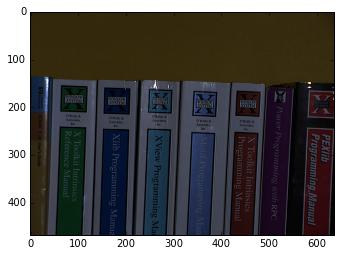

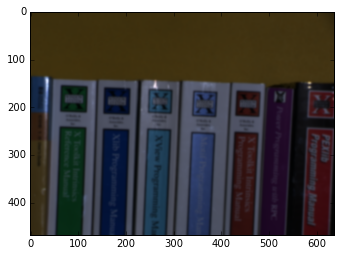

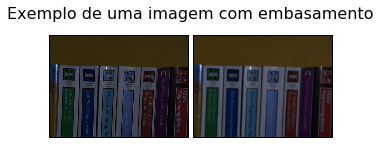

In [28]:
img = images_test[0]#cv2.imread('drawing.png')
dst = filters.gaussian_filter(img,(2,2,0), order=0)
plt.figure()
plt.imshow(normalize(img))
plt.figure()
plt.imshow(normalize(dst))

plot_gallery('Exemplo de uma imagem com embasamento',[img,dst],2,1,img.shape)


Tabela 5 image teste
------

datasets\znovabase


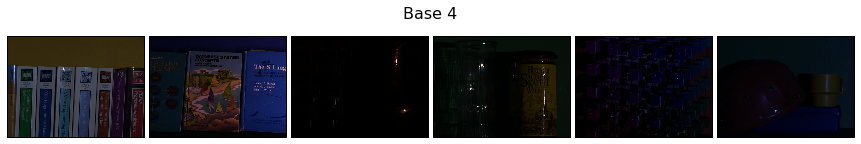

In [131]:
print(datasets[-1])
np_images,target = getBaseAndTarget(datasets[-1],isTif18=True)
images_train, images_test, target_train, target_test = train_test_split(np_images, target, 
                                                                        test_size=len(set(target)), random_state=42,stratify=target)

plot_gallery('Base 4',images_test[:6],6,1,images_test[0].shape)

Tabela 1 e tabela 3 image teste
------

datasets\objects_16_bit-11


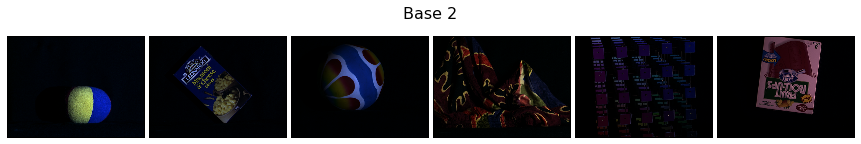

In [132]:
print(datasets[4])
np_images,target = getBaseAndTarget(datasets[4],isTif18=True)
images_train, images_test, target_train, target_test = train_test_split(np_images, target, 
                                                                        test_size=len(set(target)), random_state=42,stratify=target)

plot_gallery('Base 2',images_test[:6],6,1,images_test[0].shape)


datasets\blur_data-2


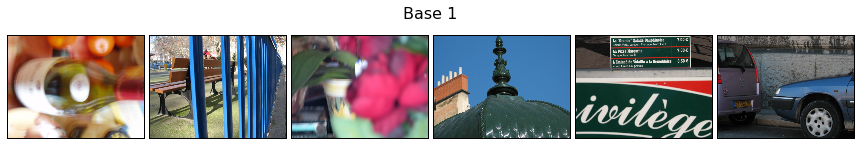

In [133]:
print(datasets[0])
np_images,target = getBaseAndTarget(datasets[0],isTif18=False)
images_train, images_test, target_train, target_test = train_test_split(np_images, target, 
                                                                        test_size=len(set(target)), random_state=42,stratify=target)

plot_gallery('Base 1',images_test[:6],6,1,images_test[0].shape)



Tabela 1 fluorescent_8_bit
------

In [134]:
print(datasets[1])
np_images,target = getBaseAndTarget(datasets[1],isTif18=False)
images_train, images_test, target_train, target_test = train_test_split(np_images, target, 
                                                                        test_size=len(set(target)), random_state=42,stratify=target)
print(len(images_train),len(images_test))
target_test

datasets\fluorescent_8_bit-9
48 6


[1, 4, 5, 3, 0, 2]

datasets\fluorescent_8_bit-9


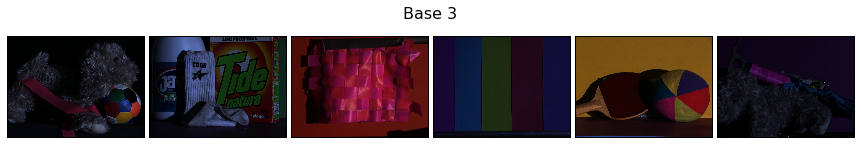

In [135]:
print(datasets[1])
np_images,target = getBaseAndTarget(datasets[1],isTif18=False)
images_train, images_test, target_train, target_test = train_test_split(np_images, target, 
                                                                        test_size=len(set(target)), random_state=42,stratify=target)

plot_gallery('Base 3',images_test[:6],6,1,images_test[0].shape)



Teste de hipotese
------

In [9]:
def getHistogramPMethodResult(images_train,images_test,target_train,target_test):
    train_histoP,test_histoP = computeHistogram(images_train,images_test,getHistogramP,math.log,filters.gaussian_laplace)
    allTestRanked = calcRanks(train_histoP,target_train,test_histoP,target_test)
    k1 = calcKnn(allTestRanked,k=1)
    k3 = calcKnn(allTestRanked,k=3)
    k5 = calcKnn(allTestRanked,k=5)

    return k1,k3,k5
def getHistogramMResult(images_train,images_test,target_train,target_test):
    train_histoP,test_histoP = computeHistogram(images_train,images_test,getHistogramM,math.log,filters.gaussian_laplace)
    allTestRanked = calcRanks(train_histoP,target_train,test_histoP,target_test)
    k1 = calcKnn(allTestRanked,k=1)
    k3 = calcKnn(allTestRanked,k=3)
    k5 = calcKnn(allTestRanked,k=5)

    return k1,k3,k5

def getHistogramThipResult(images_train,images_test,target_train,target_test):
    train_histoP,test_histoP = computeHistogram(images_train,images_test,getHistogramThip,math.log,filters.gaussian_laplace)
    allTestRanked = calcRanks(train_histoP,target_train,test_histoP,target_test)
    k1 = calcKnn(allTestRanked,k=1)
    k3 = calcKnn(allTestRanked,k=3)
    k5 = calcKnn(allTestRanked,k=5)

    return k1,k3,k5

def getHistogramThipMResult(images_train,images_test,target_train,target_test):
    train_histoP,test_histoP = computeHistogram(images_train,images_test,getHistogramThipM,math.log,filters.gaussian_laplace)
    allTestRanked = calcRanks(train_histoP,target_train,test_histoP,target_test)
    k1 = calcKnn(allTestRanked,k=1)
    k3 = calcKnn(allTestRanked,k=3)
    k5 = calcKnn(allTestRanked,k=5)
    return k1,k3,k5





In [10]:
print(datasets[-1])
np_images,target = getBaseAndTarget(datasets[-1],isTif18=True)
CV = 10
pK1 = []
pK2 = []
pK3 = []

mK1 = []
mK2 = []
mK3 = []

thipk1 = []
thipk2 = []
thipk3 = []

thimk1 = []
thimk2 = []
thimk3 = []

for i in range(CV):
    images_train, images_test, target_train, target_test = train_test_split(np_images, target,test_size=len(set(target)), 
                                                                            random_state=i,stratify=target)
    k1,k2,k3 = getHistogramPMethodResult(images_train,images_test,target_train,target_test)
    pK1.append(k1)
    pK2.append(k2)
    pK3.append(k3)
    print(pK3)
    k1,k2,k3 = getHistogramMResult(images_train,images_test,target_train,target_test)
    mK1.append(k1)
    mK2.append(k2)
    mK3.append(k3)
    print(mK3)

    k1,k2,k3 = getHistogramThipResult(images_train,images_test,target_train,target_test)
    thipk1.append(k1)
    thipk2.append(k2)
    thipk3.append(k3)
    print(thipk3)

    k1,k2,k3 = getHistogramThipMResult(images_train,images_test,target_train,target_test)
    thimk1.append(k1)
    thimk2.append(k2)
    thimk3.append(k3)
    print(thimk3)

    

datasets\znovabase
[0.1388888888888889]
[0.1111111111111111]
[0.8055555555555556]
[0.3333333333333333]
[0.1388888888888889, 0.1388888888888889]
[0.1111111111111111, 0.05555555555555555]
[0.8055555555555556, 0.8888888888888888]
[0.3333333333333333, 0.5555555555555556]
[0.1388888888888889, 0.1388888888888889, 0.16666666666666666]
[0.1111111111111111, 0.05555555555555555, 0.0]
[0.8055555555555556, 0.8888888888888888, 0.7222222222222222]
[0.3333333333333333, 0.5555555555555556, 0.5]
[0.1388888888888889, 0.1388888888888889, 0.16666666666666666, 0.05555555555555555]
[0.1111111111111111, 0.05555555555555555, 0.0, 0.1111111111111111]
[0.8055555555555556, 0.8888888888888888, 0.7222222222222222, 0.8333333333333334]
[0.3333333333333333, 0.5555555555555556, 0.5, 0.5277777777777778]
[0.1388888888888889, 0.1388888888888889, 0.16666666666666666, 0.05555555555555555, 0.05555555555555555]
[0.1111111111111111, 0.05555555555555555, 0.0, 0.1111111111111111, 0.027777777777777776]
[0.8055555555555556, 0.888

In [13]:
for i,arr in enumerate([pK1,pK2,pK3,mK1,mK2,mK3,thipk1,thipk2,thipk3,thimk1,thimk2,thimk3]):
    if i%3==0:
        print(" ")
    print("mean %.3f std %.3f"%(np.mean(arr),np.std(arr)))
    

 
mean 0.386 std 0.103
mean 0.222 std 0.058
mean 0.144 std 0.051
 
mean 0.272 std 0.081
mean 0.158 std 0.062
mean 0.075 std 0.045
 
mean 0.947 std 0.029
mean 0.853 std 0.039
mean 0.797 std 0.054
 
mean 0.764 std 0.060
mean 0.558 std 0.047
mean 0.472 std 0.060


Exemplo de indexação table 5
---

In [13]:
def calcRanks1To6(train_histogram_dict,train_target,test_histogram_dict,test_target,nr=1):
    allTestRanked = []
    for test_id in test_histogram_dict:
        allDistances=[]
        for train_id in train_histogram_dict:
            d = dist.euclidean(train_histogram_dict[train_id], test_histogram_dict[test_id])
            allDistances.append((train_id,d,train_target[train_id]))
        allDistances = sorted(allDistances,key=lambda x:x[1],reverse=False)
        allTestRanked.append((test_id,[ x for i,(x,d,target) in enumerate(allDistances[:6])] ))
    return allTestRanked

In [14]:
print(datasets[-1])
np_images,target = getBaseAndTarget(datasets[-1],isTif18=True)

images_train, images_test, target_train, target_test = train_test_split(np_images, target, 
                                                                        test_size=len(set(target)), random_state=42,stratify=target)
images_train_cp = list(images_train)
images_test_cp = list(images_test)

print(len(images_train),len(images_test))


datasets\znovabase
360 36


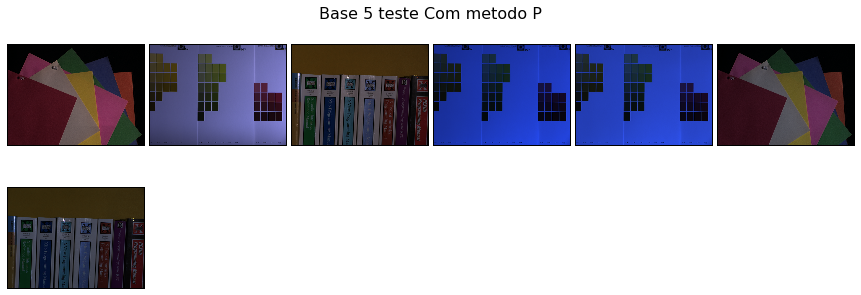

In [17]:
train_histoP,test_histoP = computeHistogram(images_train,images_test,getHistogramP,math.log,filters.gaussian_laplace)
allTestRanked = calcRanks1To6(train_histoP,target_train,test_histoP,target_test)
testedOne = allTestRanked.pop(0)
trainImages = [image for i,image in enumerate(images_train_cp) if i  in testedOne[1]]
trainImages.append(images_test_cp[testedOne[0]])
plot_gallery('Base 5 teste Com metodo P',trainImages,6,2,trainImages[0].shape)


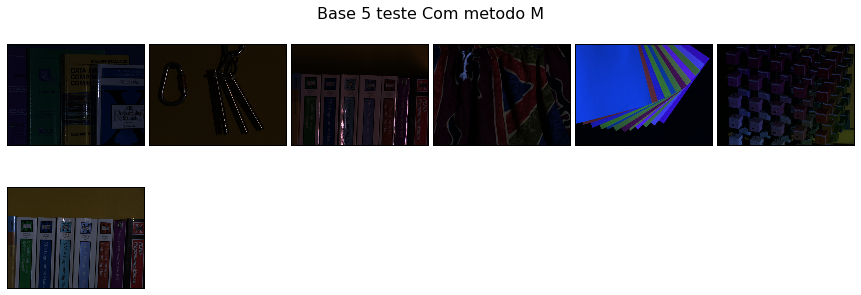

In [18]:
train_histoP,test_histoP = computeHistogram(images_train,images_test,getHistogramM,math.log,filters.gaussian_laplace)
allTestRanked = calcRanks1To6(train_histoP,target_train,test_histoP,target_test)
testedOne = allTestRanked.pop(0)
trainImages = [image for i,image in enumerate(images_train_cp) if i  in testedOne[1]]
trainImages.append(images_test_cp[testedOne[0]])
plot_gallery('Base 5 teste Com metodo M',trainImages,6,2,trainImages[0].shape)


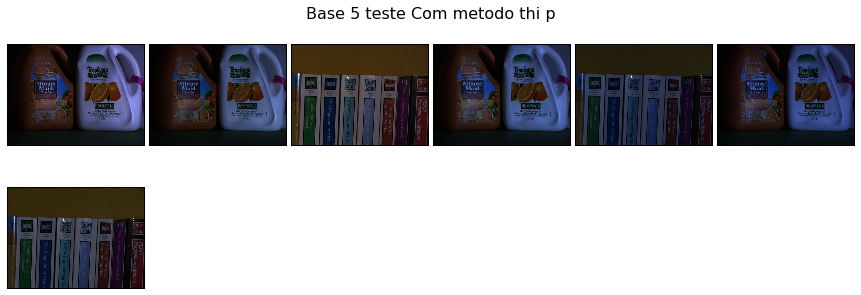

In [20]:
train_histoP,test_histoP = computeHistogram(images_train,images_test,getHistogramThip,math.log,filters.gaussian_laplace)
allTestRanked = calcRanks1To6(train_histoP,target_train,test_histoP,target_test)
testedOne = allTestRanked.pop(0)
trainImages = [image for i,image in enumerate(images_train_cp) if i  in testedOne[1]]
trainImages.append(images_test_cp[testedOne[0]])
plot_gallery('Base 5 teste Com metodo thi p',trainImages,6,2,trainImages[0].shape)


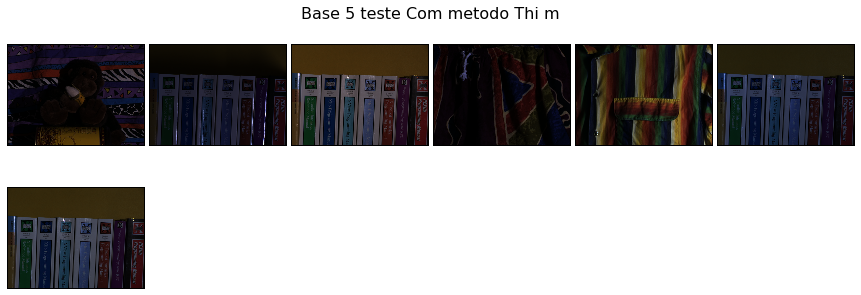

In [21]:
train_histoP,test_histoP = computeHistogram(images_train,images_test,getHistogramThipM,math.log,filters.gaussian_laplace)
allTestRanked = calcRanks1To6(train_histoP,target_train,test_histoP,target_test)
testedOne = allTestRanked.pop(0)
trainImages = [image for i,image in enumerate(images_train_cp) if i  in testedOne[1]]
trainImages.append(images_test_cp[testedOne[0]])
plot_gallery('Base 5 teste Com metodo Thi m',trainImages,6,2,trainImages[0].shape)